In [1]:
import sys
import tweepy
import sys
import tweepy
from nltk.corpus import stopwords
import re
from collections import Counter
import pandas as pd
import unidecode
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

consumer_key='S7e4bcPSpNhfHEeO64pjylwFC'
consumer_secret='cGLaCjvlDvfwqzkEn7hN3AkZlUMtrhLz7SFczsASnkexy10BBx'
access_key='959019738855862273-5rqxlIGK9aCvlo2z9JWahnFPcpfln2f'
access_secret='z2NQevSQfCdEp67FWYqnYd531J6KMCzp2zGjgESiP1JsX'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

# NLP
stemmer = SnowballStemmer('spanish')
tokenizer = RegexpTokenizer(r'\w+')
df = pd.read_csv('cities.csv', encoding='utf-8')

In [ ]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except BaseException as e:
            print('failed_on_CURSOR_NEXT', str(e))
            time.sleep(5)
            global api
            api = tweepy.API(auth)
            yield cursor.next()

In [ ]:
df.head()

In [2]:
Andalusia = ["Andalusia", "37.3399964,-4.5811614,250km"]
#Extremadura = 
Madrid = ["Madrid", "40.5248319,-3.7715628,60km"]
Catalonia = ["Catalonia", "41.8523094,1.5745043,150km"]
#CastillaLaMancha = 
#CastillaLeon = 
#Cantabria = 
Basque_Country = ["Basque_Country", "42.9911816,-2.5543023,100km"]
#ComunidadValenciana = 
Canary_Islands = ["Canary_Islands", "28.5306525,-15.7464439,400km"]
#Aragon = 
#LaRioja = 
#Navarra = 
#Asturias = 
#Murcia = 

CAS = [Andalusia, Madrid, Catalonia, Basque_Country, Canary_Islands]

In [ ]:
#Rate limits are divided into 15 minute intervals. All endpoints require authentication, 
#so there is no concept of unauthenticated calls and rate limits. There are two initial buckets available 
#for GET requests: 15 calls every 15 minutes, and 180 calls every 15 minutes.

In [ ]:
list(df[df["admin"] == "Canary Islands"]["city"])

In [ ]:
CAS_ids = []
for CA in CAS:
    CA_cities = df[df["admin"] == CA[0]]["city"]
    tweets = tweepy.Cursor(api.search, geocode = CA[1]).items(300)  
    CA_ids = []
    for tweet in tweets:
        search_location = re.search('location\':(.+?),', str(tweet.user))
        if search_location:
            found_location = search_location.group(1)
            # Delete accent
            found_location = unidecode.unidecode(found_location)
            if any(word.lower() in found_location.lower() for word in CA_cities): 
                search_id = re.search('id\': (.+?),', str(tweet.user))
                if search_id:
                    found_id = search_id.group(1)
                    CA_ids.append(int(found_id))
                    print(found_id)
    CAS_ids.append(CA_ids)


In [ ]:
columns  =["Andalusia", "Madrid", "Catalonia", "Basque_Country", "Canary_Islands"]
df_ids = pd.DataFrame(data=list(zip(CAS_ids[0], CAS_ids[1], CAS_ids[2], CAS_ids[3], CAS_ids[4])),columns=columns)
print(df_ids)

In [ ]:
df_ids.to_csv("CAS_ids2.csv", index = False)

In [ ]:
df_ids = pd.read_csv("CAS_ids.csv")

In [ ]:
df_ids.head()

In [1]:
def process_tweet(sentence):
    sentence = sentence.lower()
    sentence = unidecode.unidecode(sentence)
    words = tokenizer.tokenize(sentence)
    words = [w for w in words if not w in stopwords.words("spanish")]
    words = [w for w in words if (not "@" in w) if ("rt" != w.lower()) if (not "http" in w)]     # Delete words that contain mentions or the RT word 
    words = [stemmer.stem(w) for w in words] # Lemmatization spanish
    sentence = " ".join([word for word in words])
    return sentence

In [ ]:
# Now do for each CA
tweet_users_text = []
for CA in CAS:
    user_n = 1
    for user_id in df_ids[CA[0]]:
        tweet_n = 1
        user_id = int(user_id)
        user_id = str(user_id)
        try:      
            tweets = tweepy.Cursor(api.user_timeline, id=user_id).items(100)
            for tweet in tweets:
                tweet_text = [user_id, tweet.text, CA[0]]
                tweet_users_text.append(tweet_text)
                print("User {} of {} / Tweet {} of 100 in {}".format(user_n, len(df_ids[CA[0]]), tweet_n, CA[0]))
                tweet_n += 1
            user_n += 1
            
        except:
            "Ignore User"   

In [ ]:
df_tweets = pd.DataFrame(tweet_users_text, columns = ["id", "tweet", "location"])

In [ ]:
df_tweets.to_csv("tweet_dataset.csv", encoding='utf-8-sig', index = False)

In [4]:
df_tweets = pd.read_csv("tweet_dataset.csv")

In [ ]:
count_CA = Counter(list(df_tweets["location"])).most_common(5)
print(new_vals)

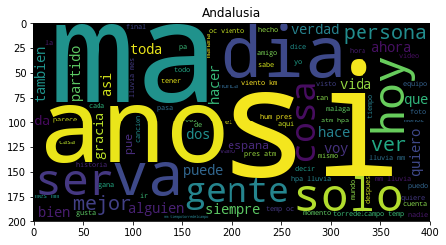

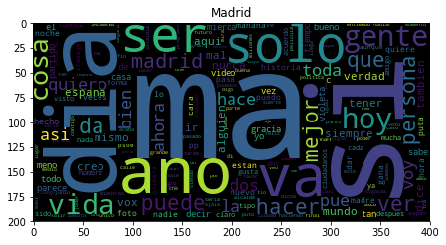

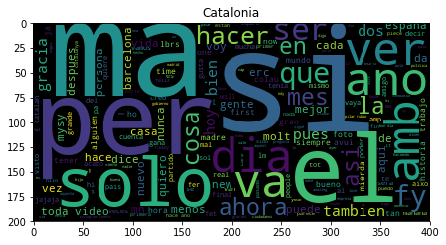

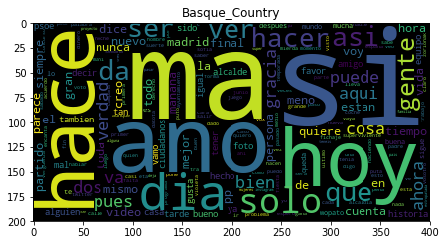

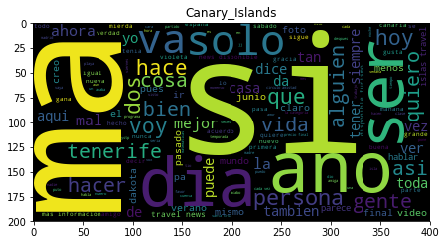

In [7]:
for CA in CAS:
    new_sentence = ""
    for index, row in df_tweets[df_tweets["location"] == CA[0]].iterrows():
        sentence = row[1].lower()
        sentence = unidecode.unidecode(sentence)
        words = sentence.split()
        words = [w for w in words if not w in stopwords.words("spanish")]
        words = [w for w in words if (not "@" in w) if ("rt" != w.lower()) if (not "http" in w)]     # Delete words that contain mentions or the RT word 
        new_sentence = new_sentence + " ".join(words)
    tweet_group  ="".join(new_sentence)
    tweet_group_wc = WordCloud().generate(tweet_group)
    plt.figure()
    plt.title(CA[0])
    plt.imshow(tweet_group_wc)
    plt.tight_layout(pad = 0)
plt.show()

In [ ]:
for CA in CAS:
    group_words = []
    for index, row in df_tweets[df_tweets["location"] == CA[0]].iterrows():
        words = process_tweet(row[1])
        group_words += words
    count_words = Counter(group_words).most_common(10)
    print("\nFor {}:".format(CA[0]))
    print(count_words)

In [ ]:
# We see that most of the words are similar for each CA
# What will have more weight in the classification will be the words for cities mentioned in the tweets
# also the expressions typical of each place